INFO: WebDriver 已啟動。
INFO: 已導航至 https://dmz26.moea.gov.tw/GA/common/Common.aspx?code=N&no=7
INFO: 已選擇起始日期值：095
INFO: 已點擊查詢按鈕。
INFO: 提取到 18 筆資料。
INFO: 數據處理完成。
INFO: 線性回歸模型訓練完成。
INFO: 模型評估完成。


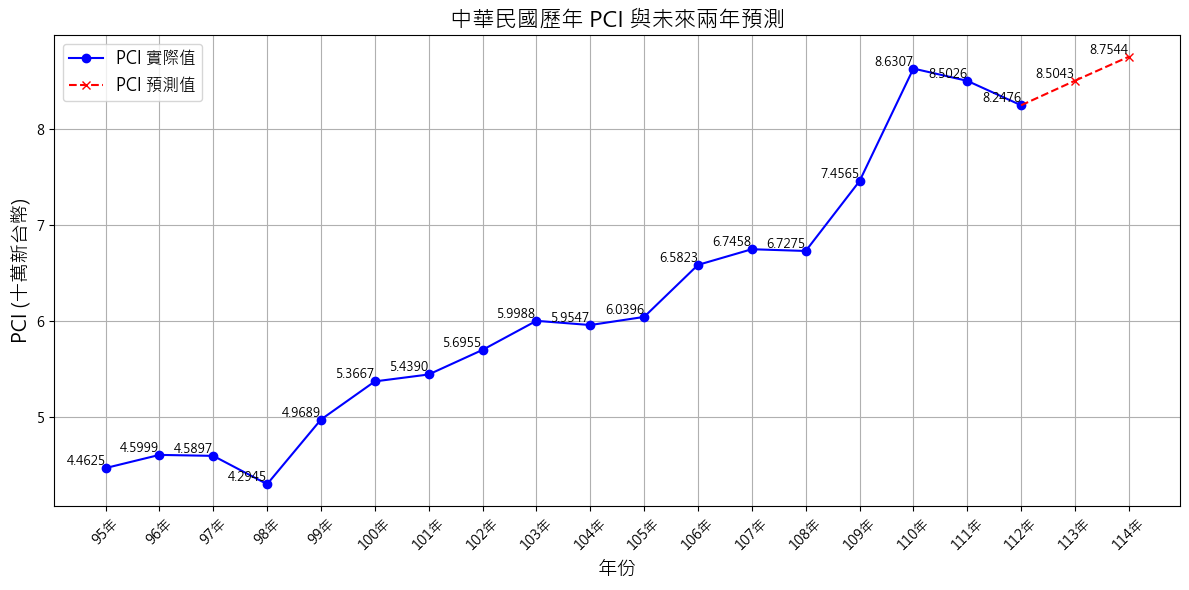

INFO: 圖表繪製完成。


預測 113年 的 PCI 為 8.5043 十萬新台幣
預測 114年 的 PCI 為 8.7544 十萬新台幣

模型評估指標：
均方誤差 (MSE): 0.126002
平均絕對誤差 (MAE): 0.265134
R² 分數: 0.9304


INFO: WebDriver 已關閉。


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select, WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import logging
import sys

# 設定日誌
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def setup_webdriver():
    options = webdriver.ChromeOptions()
    # 如果不需要最大化視窗，可以移除此行
    # options.add_argument("--start-maximized")
    try:
        driver = webdriver.Chrome(options=options)
        logging.info("WebDriver 已啟動。")
        return driver
    except Exception as e:
        logging.error(f"WebDriver 啟動失敗：{e}")
        sys.exit(1)

def navigate_to_page(driver, url):
    driver.get(url)
    logging.info(f"已導航至 {url}")

def select_start_date(driver, wait, value="095"):
    wait.until(EC.visibility_of_element_located((By.ID, "hldContent_ddlDateBeg")))
    select_element = driver.find_element(By.ID, "hldContent_ddlDateBeg")
    select = Select(select_element)
    select.select_by_value(value)
    logging.info(f"已選擇起始日期值：{value}")

def click_query(driver, wait):
    wait.until(EC.element_to_be_clickable((By.ID, "hldContent_btnQuery")))
    query_button = driver.find_element(By.ID, "hldContent_btnQuery")
    query_button.click()
    logging.info("已點擊查詢按鈕。")

def extract_data(driver, wait):
    wait.until(EC.visibility_of_element_located((By.ID, "divTableReport")))
    wait.until(EC.visibility_of_element_located((By.ID, "hldContent_tabReport")))
    
    table = driver.find_element(By.ID, "hldContent_tabReport")
    tbody = table.find_element(By.TAG_NAME, "tbody")
    tr_elements = tbody.find_elements(By.XPATH, ".//tr[@style='height:18pt;']")
    
    years = []
    PCIs = []
    
    for tr in tr_elements:
        td_elements = tr.find_elements(By.TAG_NAME, "td")
        year = None
        PCI = None
        for td in td_elements:
            align = td.get_attribute("align")
            if align == "center" and not year:
                year = td.text.strip()
            elif align == "right" and not PCI:
                PCI = td.text.strip()
            if year and PCI:
                break
        if year and PCI:
            years.append(year)
            PCIs.append(PCI)
        else:
            logging.warning(f"無法在 tr 中找到所需的 td。tr 內容：{tr.text}")
    
    logging.info(f"提取到 {len(years)} 筆資料。")
    return years, PCIs

def process_data(years, PCIs, scaling_factor=10, exchange_rate=30):
    X = np.array(range(len(years))).reshape(-1, 1)
    processed_PCIs = [int(pci.replace(' ', '')) for pci in PCIs]
    y_TWD = np.array([pci * exchange_rate / (scaling_factor * 10000) for pci in processed_PCIs])
    last_year_num = int(years[-1].replace('年', ''))
    logging.info("數據處理完成。")
    return X, y_TWD, last_year_num

def perform_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    logging.info("線性回歸模型訓練完成。")
    return model, y_pred

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    logging.info("模型評估完成。")
    return {"MSE": mse, "MAE": mae, "R2": r2}

def plot_data(years, y_TWD, future_years, predicted_PCI_TWD, all_years, all_PCIs_TWD, scaling_factor):
    plt.rcParams['font.family'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(12, 6))
    
    plt.plot(years, y_TWD, marker='o', label='PCI 實際值', color='blue')
    plt.plot(future_years, predicted_PCI_TWD, marker='x', linestyle='--', color='red', label='PCI 預測值')
    plt.plot([years[-1], future_years[0]], [y_TWD[-1], predicted_PCI_TWD[0]], linestyle='--', color='red')
    
    for x, y_val in zip(years, y_TWD):
        plt.text(x, y_val, f"{y_val:.4f}", fontsize=9, ha='right', va='bottom')
    for x, y_val in zip(future_years, predicted_PCI_TWD):
        plt.text(x, y_val, f"{y_val:.4f}", fontsize=9, ha='right', va='bottom')
    
    if scaling_factor == 10:
        y_label = 'PCI (十萬新台幣)'
        unit_display = '十萬'
    else:
        y_label = f'PCI (十{scaling_factor}萬新台幣)'
        unit_display = f'十{scaling_factor}萬'
    
    plt.title('中華民國歷年 PCI 與未來兩年預測', fontsize=16)
    plt.xlabel('年份', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.xticks(all_years, rotation=45)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    logging.info("圖表繪製完成。")

def main(scaling_factor=10, exchange_rate=30):
    url = "https://dmz26.moea.gov.tw/GA/common/Common.aspx?code=N&no=7"
    driver = setup_webdriver()
    
    try:
        navigate_to_page(driver, url)
        wait = WebDriverWait(driver, 10)
        select_start_date(driver, wait, value="095")
        click_query(driver, wait)
        years, PCIs = extract_data(driver, wait)
        
        if not years or not PCIs:
            logging.error("未提取到任何資料，終止程式。")
            sys.exit(1)
        
        X, y_TWD, last_year_num = process_data(years, PCIs, scaling_factor, exchange_rate)
        model, y_pred = perform_regression(X, y_TWD)
        
        future_indices = np.array([[len(X)], [len(X)+1]])
        predicted_PCI_TWD = model.predict(future_indices)
        
        metrics = evaluate_model(y_TWD, y_pred)
        
        future_years = [f"{last_year_num + 1}年", f"{last_year_num + 2}年"]
        all_years = years + future_years
        all_PCIs_TWD = y_TWD.tolist() + predicted_PCI_TWD.tolist()
        
        plot_data(years, y_TWD, future_years, predicted_PCI_TWD, all_years, all_PCIs_TWD, scaling_factor)
        
        for year, pci in zip(future_years, predicted_PCI_TWD):
            print(f"預測 {year} 的 PCI 為 {pci:.4f} {'十萬' if scaling_factor == 10 else f'十{scaling_factor}萬'}新台幣")
        
        print("\n模型評估指標：")
        print(f"均方誤差 (MSE): {metrics['MSE']:.6f}")
        print(f"平均絕對誤差 (MAE): {metrics['MAE']:.6f}")
        print(f"R² 分數: {metrics['R2']:.4f}")
        
    except Exception as e:
        logging.error(f"操作失敗：{e}")
    finally:
        driver.quit()
        logging.info("WebDriver 已關閉。")


main(10, 30)
# 第一個arg為 '每幾萬為一單位 目前預設設定為 '每10萬'(新台幣)'
# 第二個arg為 '匯率' 此匯率為美金與新台幣 目前預設設定為 '1美金=30新台幣' 
# 以上兩個args可以自行更換
